In [1]:
# INSTRUCTIONS: NOTEBOOK WILL RUN END TO END WITH NO CHANGES NECCESSARY. EITHER RUN END TO END OR RUN CELLS SEQUENTIALLY
# WARNING! RUNNING CELLS OUT OF SEQUENCE WILL CAUSE NOTEBOOK TO ERROR. PLEASE RUN SEQUENTIALLY OR END TO END.
# WRITTEN BY JONH ADE-OJO 31/01/2021


import numpy as np
import pandas as pd


# DEFINE FUNCTION TO READ FILES FROM GITHUB REPOS
def read_file(url):

    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """

    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df


# READ FILE FROM GITHUB REPO
url = "https://github.com/john-adeojo/tidytuesday/blob/master/data/2020/2020-07-14/astronauts.csv"
astronauts = read_file(url)

# READ ASTRONAUT MISSION FILE FROM GITHUB
url = "https://github.com/john-adeojo/Astronauts/blob/main/Space_Corrected.csv"
missions = read_file(url)

In [2]:
# RENAME COLUMNS TO HAVE UNDERSCORES: HELPS DEAL WITH NUANCES IN DATA MANIPULATION
missions.columns = (
    missions.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

# FILL IN MISSING VALUES FROM DATA
values = {
    "ascend_shuttle": "unavailable",
    "descend_shuttle": "unavailable",
    "mission_title": "unavailable",
    "selection": "Unavailable",
}
astronauts.fillna(value=values, inplace=True)

In [3]:
# FUNTION FOR GETTING FREQUENCIES OF FEATURES

# DEFINE A FUNCTION TO GENERATE FREQUENCIES
def get_freques(data, feature):
    """
    Pass in pandas data frame
    and categorical feature
    returns dataframe of frequencies
    data: pandas data frame
    feature: column name in pandas dataframe (str)
    """
    df = (data[feature].value_counts()).to_frame()
    df = df.reset_index()
    df.columns = [feature, "counts"]

    return df

In [4]:
# SCRIPT BELOW RECATEGORISES HIGH CARDINALITY FEATURES & MERGES ONTO ASTRONAUT DATA

# GET FREQUENCY TABLES FOR HIGH CARDINALITY FEATURES
nationality = get_freques(astronauts, "nationality")
selection = get_freques(astronauts, "selection")
occupation = get_freques(astronauts, "occupation")

# ----------------------------------------------------------------------------------#

# RECATEGORISE NATIONALITY
q = 0.80  # the top 20% of observations by frequencey
nationality["nationality_2"] = np.where(
    nationality.counts > nationality.counts.quantile(q=q),
    nationality.nationality,
    "Rest of world",
)

# RECATEGORISE OCCUPATION
q = 0.80  # the top 20% of observations by frequencey
occupation["occupation_2"] = np.where(
    occupation.counts > occupation.counts.quantile(q=q),
    occupation.occupation,
    "Other",
)


# RECATEGORISE SELECTION
conditions = [
    ((selection.selection.str.contains("nasa", case=False)) == True),
    ((selection.selection.str.contains("TsPK", case=False)) == True),
    ((selection.selection.str.contains("NPOE", case=False)) == True),
    ((selection.selection.str.contains("China", case=False)) == True),
]

choices = ["NASA", "TsPK", "NPOE", "China-1"]
selection["selection_2"] = np.select(conditions, choices, default="Other")

# ----------------------------------------------------------------------------------#

# MERGE RECATEGORISED FEATURES ONTO ASTRONAUT DATA SET
astronauts = pd.merge(astronauts, nationality, how="left", on="nationality").drop(
    columns="counts"
)
astronauts = pd.merge(astronauts, occupation, how="left", on="occupation").drop(
    columns="counts"
)
astronauts = pd.merge(astronauts, selection, how="left", on="selection").drop(
    columns="counts"
)

In [5]:
# CREATE NEW FEATURES: ASTRONAUT DATA

# AGE
astronauts["age_at_selection"] = astronauts.year_of_selection - astronauts.year_of_birth
astronauts["age_on_mission"] = astronauts.year_of_mission - astronauts.year_of_birth
astronauts["age_on_mission"] = astronauts.year_of_mission - astronauts.year_of_birth

# DAYS
astronauts["days_mission"] = astronauts.hours_mission / 24

# MISSION ID ASSUMES ONE MISSION IS CATEGORISED BY A MISSION TITLE, MISSION YEAR AND ASCEND SHUTTLE (ASSUMES ONE ASCENDING SHUTTLE PER MISSION)
astronauts["missionid"] = (
    astronauts.mission_title
    + "_"
    + astronauts.year_of_mission.astype(str)
    + "_"
    + astronauts.ascend_shuttle
)

# ----------------------------------------------------------------------------------#
# CREATE NEW FEATURES: MISSION DATA

# MISSION CREATE YEAR VARIABLE
missions.datum = pd.to_datetime(missions.datum, utc=True)
missions["year"] = missions.datum.dt.year

pd.set_option("display.max_columns", None)
astronauts.head()

# CREATE STATUS MISSION 2: COUNTER NUANCE WITH AGGREGATIONS FOR STATUS_MISSION VARIABLES
missions["status_mission_2"] = missions.status_mission

In [6]:
# SUMMARISE ASTRONAUT DATA AT DIFFERENT LEVELS OF ANALYSIS


# DEFINE FUNCTION TO FLATTEN MULTI-INDEX AFTER AGGREGATION (HELPS WITH PLOTTING CHARTS LATER)
def flatten(data):
    """
    Flattens multilevel column index
    after aggregation
    data: pandas dataframe with multi-index column

    """
    data.columns = [
        "_".join(col_name).rstrip("_") for col_name in data.columns.to_flat_index()
    ]


# ----------------------------------------------------------------------------------#

# AGGREGATIONS GROUP 1 : ADD IN AGGREGATION HERE
aggregations = {
    "age_on_mission": [min, max, np.mean],
    "age_at_selection": np.mean,
    "name": "count",
    "hours_mission": sum,
    "eva_hrs_mission": [max, sum],
    "missionid": "count",
    "field21": [max, sum],
}


# SHUTTLE LEVEL: ORBIT

# SHUTTLE LEVEL: ASTRONAUT, ORBIT & MISSION
group = ["in_orbit", "missionid", "name"]
orbit_mission_astronauts = astronauts.groupby(by=group).agg(aggregations).reset_index()
flatten(orbit_mission_astronauts)

# SHUTTLE LEVEL: ORBIT
orbit = astronauts.loc[:, ("missionid", "in_orbit")]
orbit.drop_duplicates(inplace=True)
group = ["in_orbit"]
aggregations2 = {"missionid": "count"}
orbit_mission = orbit.groupby(by=group).agg(aggregations2).reset_index()


# ----------------------------------------------------------------------------------#

# ASTRONAUTS LEVEL AGGREGATIONS

# ONLY LOOK AT ASTRONAUTS WITH EVA HOURS GREATER THAN 0 (SPACE WALKS ONLY)
astro_spw = astronauts.loc[astronauts.eva_hrs_mission > 0]

# ASTRONAUT LEVEL
group = ["name"]
name_astronauts_spw = astro_spw.groupby(by=group).agg(aggregations).reset_index()
flatten(name_astronauts_spw)

# ASTRONAUT/MISSION LEVEL
group = ["name", "missionid"]
name_mission_astronauts_spw = (
    astro_spw.groupby(by=group).agg(aggregations).reset_index()
)
flatten(name_mission_astronauts_spw)

# ----------------------------------------------------------------------------------#

# AGGREGATIONS FOR NON-SHUTTLE/ASTRONAUT LEVEL AGGREGATIONS: ADD IN AGGREGATION HERE
aggregations = {"missionid": "count"}

# REMOVE ASTRONAUT LEVEL DATA FOR AGGREGATION: NATIONALITY
nationality_astro = astronauts.loc[:, ("missionid", "nationality_2")]
nationality_astro.drop_duplicates(inplace=True)

# NATIONALITY LEVEL DATA SET
group = ["nationality_2"]
nationality_missions = (
    nationality_astro.groupby(by=group).agg(aggregations).reset_index()
)
nationality_missions.sort_values(by="missionid", ascending=False, inplace=True)

# REMOVE ASTRONAUT LEVEL DATA FOR AGGREGATION: SELECTION
selection_astro = astronauts.loc[:, ("missionid", "selection_2")]
selection_astro.drop_duplicates(inplace=True)

# SELECTION LEVEL DATA SET
group = ["selection_2"]
selection_missions = selection_astro.groupby(by=group).agg(aggregations).reset_index()
selection_missions.sort_values(by="missionid", ascending=False, inplace=True)

# ----------------------------------------------------------------------------------#

# AGGREGATE MISSION DATA AT DIFFERENT LEVELS OF ANALYSIS
aggregations = {"status_mission_2": "count"}

# AGGREGATE MISSIONS AT COMPANY LEVEL
group = ["company_name", "status_mission"]
company_missions_result = missions.groupby(by=group).agg(aggregations).reset_index()

group = ["company_name"]
company_tot = missions.groupby(by=group).agg(aggregations).reset_index()

# MERGE LOCATIONS AND MISSION RESULT AGGS
company_missions = pd.merge(
    company_missions_result, company_tot, how="left", on="company_name"
)

# CONVERT COUNTS TO PERCENTAGES
company_missions["percentage"] = (
    company_missions.status_mission_2_x / company_missions.status_mission_2_y
)

# HIGHEST FAILURE RATE FOR COMPANIES WITH MORE THAN 1 MISSSION
failed_missions = company_missions.loc[(company_missions.status_mission == "Failure")]

# ----------------------------------------------------------------------------------#

# AGGRETATE AT YEAR LEVEL TO CREATE TIME SERIES OF MISSIONS
group = ["year"]
missions_time_series = missions.groupby(by=group).agg(aggregations).reset_index()


# ----------------------------------------------------------------------------------#

# WHAT COMPANIES HAD THE MOST MISSIONS IN 2020
missions_2020 = missions.loc[missions.year == 2020]
group = ["company_name"]
companies_2020 = missions_2020.groupby(by=group).agg(aggregations).reset_index()

In [7]:
# CREATE TOP 10s FROM AGGREGATED DATA

# DEFINE FUNCTION TO SORT TABLES
def sort(data):
    data.sort_values(ascending=False)


# TOP 10 ASTRONAUTS WHO HAVE PERFORMED SPACEWALKS BY:
# TOTAL TIME ON SPACE WALK (EVA) IN TOTAL
ten_astro_spacewalk_t = name_astronauts_spw.nlargest(10, ["eva_hrs_mission_sum"])[
    ["name", "eva_hrs_mission_sum"]
]


# TOTAL SPACE WALKS COMPLETED
ten_astro_spacewalk__num = name_astronauts_spw.nlargest(10, ["field21_sum"])[
    ["name", "field21_sum"]
]

# TIME ON A SINGLE SPACE WALK
ten_astro_spacewalk_s = name_mission_astronauts_spw.nlargest(
    10, ["eva_hrs_mission_max"]
)[["name", "eva_hrs_mission_max"]]

# OLDEST PEOPLE ON SPACE WALK
ten_astro_oldest_spacewalk = name_astronauts_spw.nlargest(10, ["age_on_mission_max"])[
    ["name", "age_on_mission_max"]
]


# ----------------------------------------------------------------------------------#

# TOP 10 ORBIT SHUTTLES:
# NUMBER OF MISSIONS IN TOTAL
ten_orbit_shuttle_missions = orbit_mission.nlargest(10, ["missionid"])[
    ["in_orbit", "missionid"]
]

# TOP 10 ORBIT SHUTTLES/MISSION/ASTRONAUT LEVEL:

# NUMBER OF HOURS IN ORBIT ON A SINGLE MISSION
ten_single_orbit_hours = orbit_mission_astronauts.nlargest(10, ["hours_mission_sum"])[
    ["name", "hours_mission_sum"]
]


# ----------------------------------------------------------------------------------#

# TOP 10 COMPANIES BY FAILURES MISSIONS UNDERTAKEN
failed = failed_missions.nlargest(10, ["percentage"])[
    ["company_name", "percentage", "status_mission_2_y"]
]
# ONLY LOOK AT COMPANIES WITH MORE THAN 1 MISSION IN TOTAL
ten_company_missions_failed = failed.loc[failed.status_mission_2_y > 1]

# TOP 10 COMPANIES STILL EXPORING SPACE IN 2020
ten_company_missions_2020 = companies_2020.nlargest(10, ["status_mission_2"])[
    ["company_name", "status_mission_2"]
]

In [8]:
# GENERATE RECORD ACHEIVEMENTS:
# OLDEST PERSON IN SPACE
oldest_person_in_space = astronauts.loc[
    astronauts.age_on_mission == astronauts.age_on_mission.max()
]

# FIRST PERSON IN SPACE
first_person_in_space = astronauts.loc[
    (astronauts.year_of_mission == astronauts.year_of_mission.min())
]

# FIRST PERSON TO WALK IN SPACE
first_person_spw = astro_spw.loc[
    (astro_spw.year_of_mission == astro_spw.year_of_mission.min())
]


# ISOLATE FEMALE ASTRONAUTS
female_astronauts = astronauts.loc[astronauts.sex == "female"]
# FIRST WOMAN IN SPACE
first_woman_in_space = female_astronauts.loc[
    (female_astronauts.year_of_mission == female_astronauts.year_of_mission.min())
]

# FIRST WOMAN TO DO A SPACE WALK
female_astro_spw = female_astronauts.loc[female_astronauts.eva_hrs_mission > 0]
first_woman_spw = female_astro_spw.loc[
    (female_astro_spw.year_of_mission == female_astro_spw.year_of_mission.min())
]

# ----------------------------------------------------------------------------------#

# EXPLOSIONS
# FIRST EXPLOSION
explosions = astronauts.loc[
    (astronauts.in_orbit == "explosion")
    | (astronauts.ascend_shuttle == "explosion")
    | (astronauts.descend_shuttle == "explosion")
]
First_Explosion = explosions.loc[
    explosions.year_of_mission == explosions.year_of_mission.min()
]

In [9]:
# DEFINE FUNTION TO GENRATE UNIVARIATE BAR PLOTS
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


def bar(data, name):
    """
    plots bar chart
    name: titl of plot, as str
    data: pandas dataframe with 1 categorical column and 1 numeric column
    """

    x_ = str(data.columns[1])
    y_ = str(data.columns[0])
    x_col = data[x_]
    y_col = data[y_]

    sns.set_style(style="darkgrid")
    sns.color_palette("pastel")
    sns.set_context("paper", font_scale=1.5)
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(x=x_col, y=y_col, data=data)
    ax.set_xlabel("")
    ax.set_title(name)
    plt.savefig(name)
    plt.show()

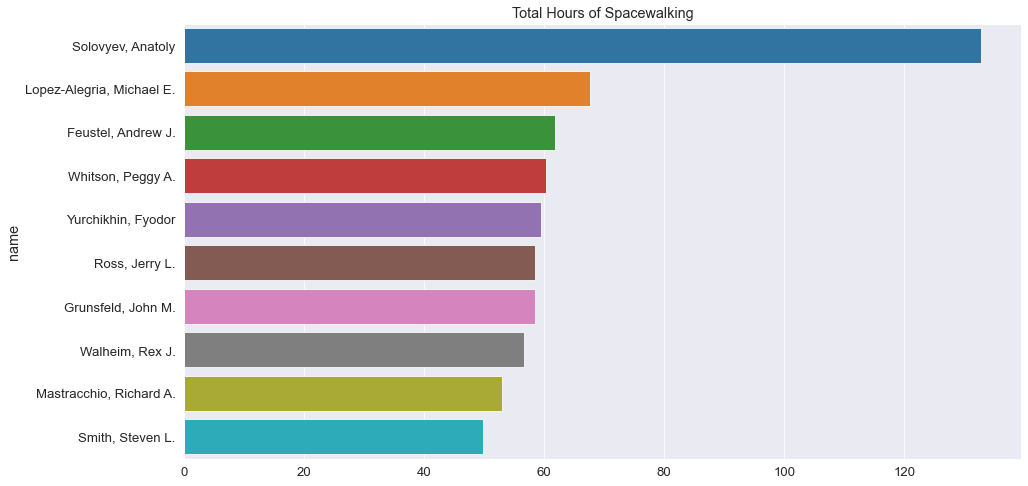

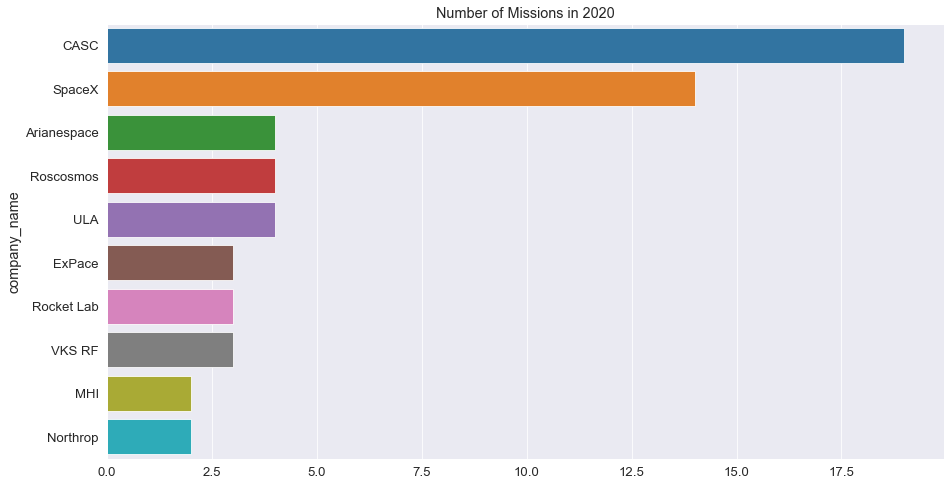

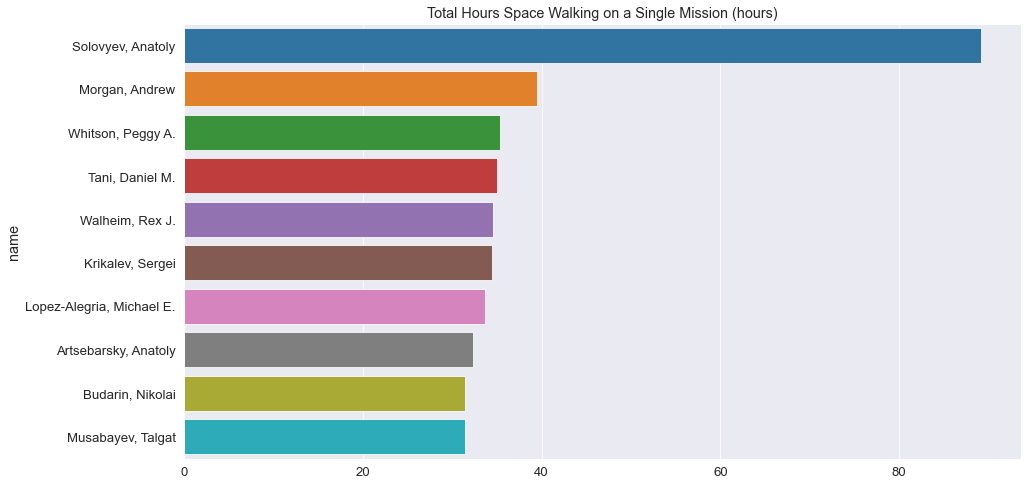

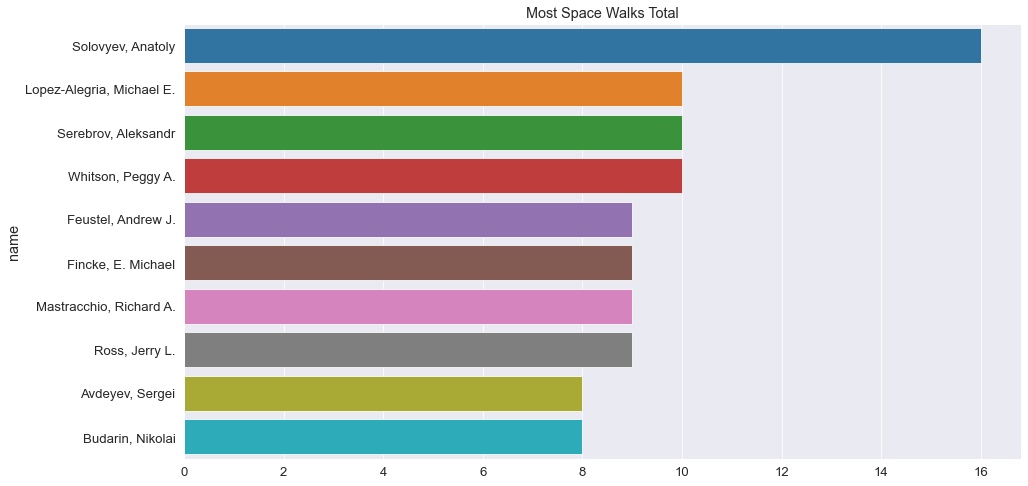

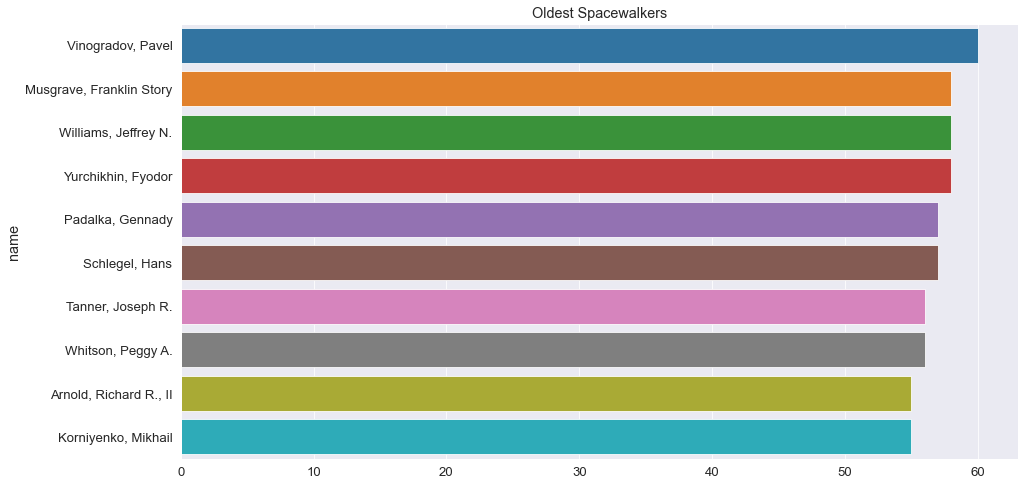

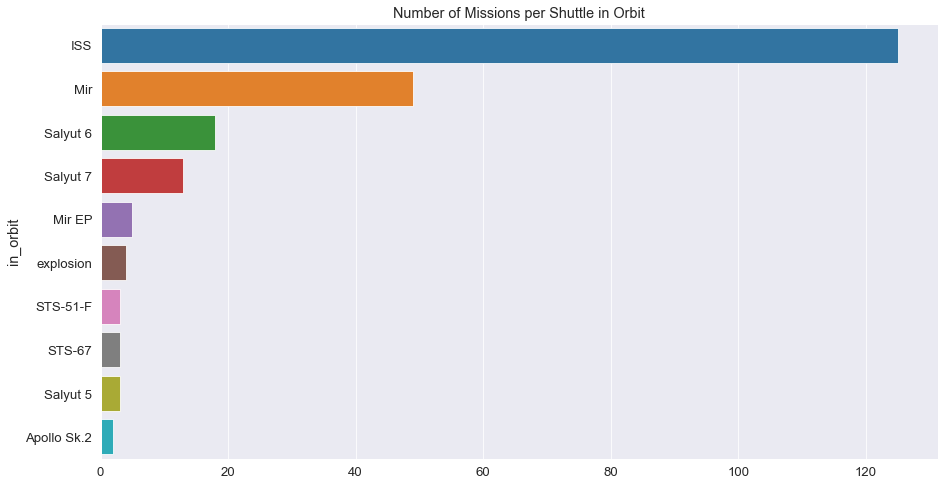

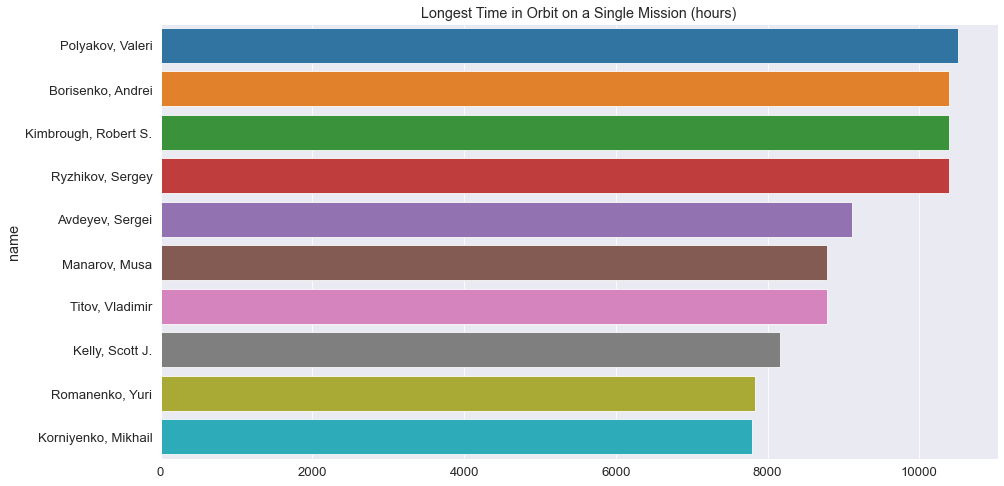

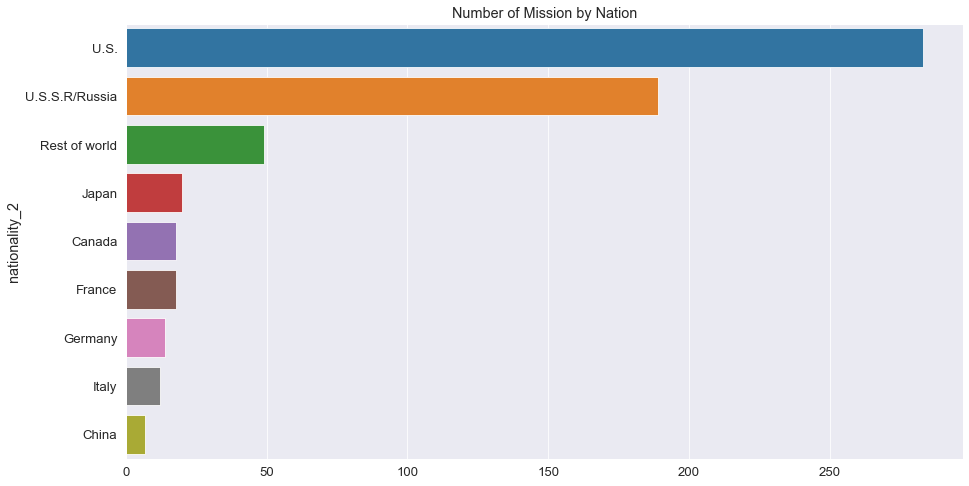

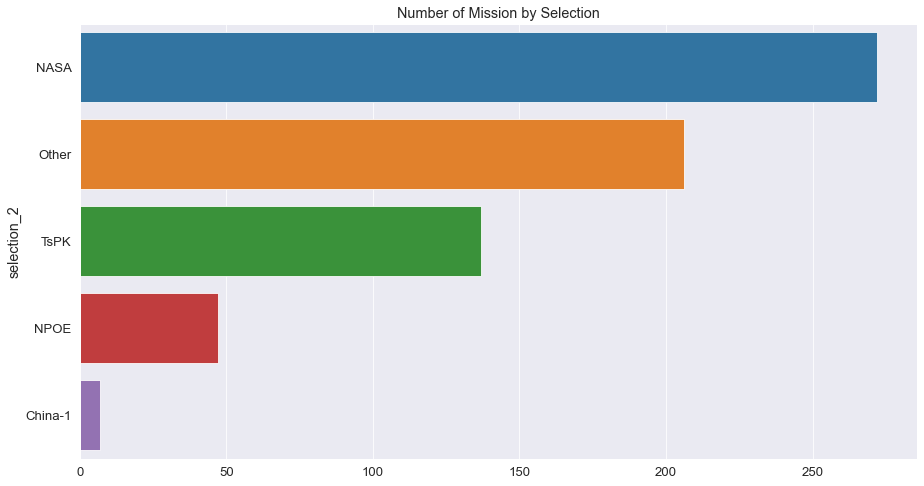

In [10]:
# PLOT BAR CHARTS FOR ASTRONAUTS

# TOP TEN LONGEST TOTAL ASTRONAUT SPACEWALKS
bar(ten_astro_spacewalk_t, "Total Hours of Spacewalking")

# TOP 10 COMPANIES THAT HAD MISSIONS DURING 2020
bar(ten_company_missions_2020, "Number of Missions in 2020")

# TOP 10: LONGEST SPACEWALK ON A SINGLE MISSION
bar(
    ten_astro_spacewalk_s,
    "Total Hours Space Walking on a Single Mission (hours)",
)

# TOP 10: MOST INSTANCES OF A SPACEWALK TOTAL
bar(ten_astro_spacewalk__num, "Most Space Walks Total")

# TOP 10: OLDEST PEOPLE TO DO A SPACEWALK
bar(ten_astro_oldest_spacewalk, "Oldest Spacewalkers")

# TOP 10: MISSIONS FOR SHUTTLES IN ORBIT
bar(ten_orbit_shuttle_missions, "Number of Missions per Shuttle in Orbit")

# TOP 10: LONGEST TIME IN ORBIT ON A SINGLE MISSION
bar(ten_single_orbit_hours, "Longest Time in Orbit on a Single Mission (hours)")

# NUMBER OF MISSIONS BY NATION
bar(nationality_missions, "Number of Mission by Nation")

# NUMBER OF MISSIONS BY SELECTION
bar(selection_missions, "Number of Mission by Selection")

In [11]:
ten_astro_spacewalk_t

,name,eva_hrs_mission_sum
182,"Solovyev, Anatoly",132.79
106,"Lopez-Alegria, Michael E.",67.67
46,"Feustel, Andrew J.",61.80
217,"Whitson, Peggy A.",60.31
228,"Yurchikhin, Fyodor",59.43
159,"Ross, Jerry L.",58.53
66,"Grunsfeld, John M.",58.45
212,"Walheim, Rex J.",56.73
117,"Mastracchio, Richard A.",53.07
181,"Smith, Steven L.",49.80


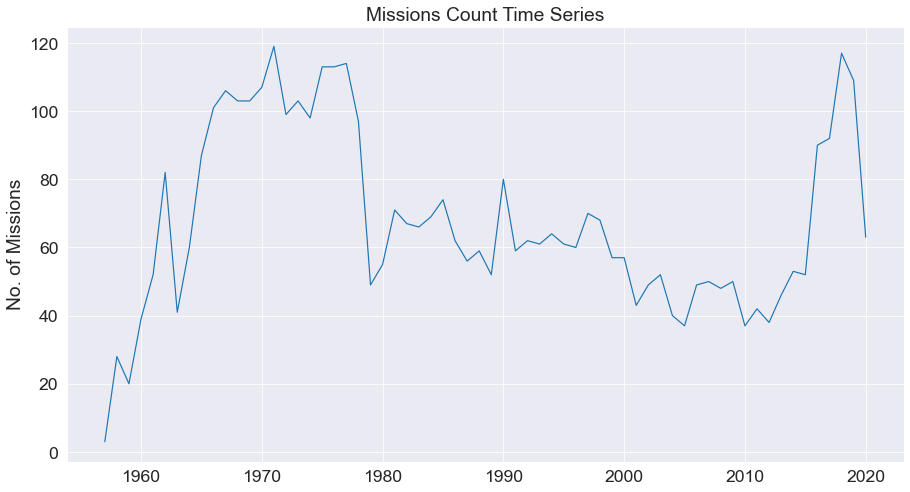

In [12]:
# GENERATE CHART TO PLOT TIMESRIES


def line(data, name):
    """
    plot timeseries
    takes data and name as input
    data: pandas dataframe
    name: plot title, as str
    """
    x_col = data.columns[0]
    y_col = data.columns[1]

    sns.set_style(style="darkgrid")
    sns.set_context("paper", font_scale=2)
    plt.figure(figsize=(15, 8))
    ax = sns.lineplot(x=x_col, y=y_col, data=data)
    ax.set_xlabel("")
    ax.set_ylabel("No. of Missions")
    ax.set_title(name)
    plt.savefig(name)
    plt.show()


line(missions_time_series, "Missions Count Time Series")

In [13]:
# OLDEST PERSON IN SPACE
oldest_person_in_space

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
3,4,3,1,"Glenn, John H., Jr.","Glenn, John H., Jr.",male,1921,U.S.,military,NASA Astronaut Group 2,1959,2,2,PSP,1998,STS-95,STS-95,STS-95,STS-95,213.0,218.0,0,0.0,0.0,U.S.,Other,NASA,38,77,8.875,STS-95_1998_STS-95


In [14]:
# FIRST PERSON IN SPACE
first_person_in_space

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
0,1,1,1,"Gagarin, Yuri",ГАГАРИН Юрий Алексеевич,male,1934,U.S.S.R/Russia,military,TsPK-1,1960,1,1,pilot,1961,Vostok 1,Vostok 1,Vostok 2,Vostok 3,1.77,1.77,0,0.0,0.0,U.S.S.R/Russia,pilot,TsPK,26,27,0.073750,Vostok 1_1961_Vostok 1
1,2,2,2,"Titov, Gherman",ТИТОВ Герман Степанович,male,1935,U.S.S.R/Russia,military,TsPK-1,1960,1,1,pilot,1961,Vostok 2,Vostok 2,Vostok 2,Vostok 2,25.00,25.30,0,0.0,0.0,U.S.S.R/Russia,pilot,TsPK,25,26,1.041667,Vostok 2_1961_Vostok 2


In [15]:
# FIRST PERSON TO WALK IN SPACE
first_person_spw

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
23,24,15,11,"Leonov, Aleksei",ЛЕОНОВ Алексей Архипович,male,1934,U.S.S.R/Russia,military,TsPK-1,1960,1,2,pilot,1965,Voskhod 2,Voskhod 2,Voskhod 2,Voskhod 2,26.03,168.53,1,0.73,0.73,U.S.S.R/Russia,pilot,TsPK,26,31,1.084583,Voskhod 2_1965_Voskhod 2
34,35,19,8,"White, Edward H., II","White, Edward H., II",male,1930,U.S.,military,1962 NASA group 2,1962,1,1,pilot,1965,Gemini 4,Gemini 4,Gemini 4,Gemini 4,97.93,97.93,1,0.33,0.33,U.S.,pilot,NASA,32,35,4.080417,Gemini 4_1965_Gemini 4


In [16]:
# FIRST WOMAN IN SPACE
first_woman_in_space

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
17,18,10,6,"Tereshkova, Valentina",ТЕРЕШКОВА Валентина Владимировна,female,1937,U.S.S.R/Russia,military,VVS Women,1962,1,1,pilot,1963,Vostok 6,Vostok 6,Vostok 6,Vostok 6,70.83,70.83,0,0.0,0.0,U.S.S.R/Russia,pilot,Other,25,26,2.95125,Vostok 6_1963_Vostok 6


In [17]:
# FIRST WOMAN TO DO A SPACE WALK
first_woman_spw

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
215,216,111,53,"Savitskaya, Svetlana",Светлана Евгеньевна Савицкая,female,1948,U.S.S.R/Russia,civilian,MAP,1980,2,2,flight engineer,1984,Salyut 7,Soyuz T­12,Salyut 7,Soyuz T­12,283.0,473.1,1,3.58,3.58,U.S.S.R/Russia,Other,Other,32,36,11.791667,Salyut 7_1984_Soyuz T­12
312,313,150,80,"Sullivan, Kathryn D.","Sullivan, Kathryn D.",female,1951,U.S.,civilian,1978 NASA group,1978,1,3,MSP,1984,STS-41-G,STS-41-G,STS-41-G,STS-41-G,197.5,532.0,1,3.45,3.45,U.S.,MSP,NASA,27,33,8.229167,STS-41-G_1984_STS-41-G


In [18]:
# FIRST EXPLOSION
First_Explosion

,id,number,nationwide_number,name,original_name,sex,year_of_birth,nationality,military_civilian,selection,year_of_selection,mission_number,total_number_of_missions,occupation,year_of_mission,mission_title,ascend_shuttle,in_orbit,descend_shuttle,hours_mission,total_hrs_sum,field21,eva_hrs_mission,total_eva_hrs,nationality_2,occupation_2,selection_2,age_at_selection,age_on_mission,days_mission,missionid
307,308,147,77,"Resnik, Judith A.","Resnik, Judith A.",female,1949,U.S.,civilian,NASA-9,1978,2,2,MSP,1985,STS-51-L,STS-51-L,explosion,explosion,0.0,144.0,0,0.0,0.0,U.S.,MSP,NASA,29,36,0.0,STS-51-L_1985_STS-51-L


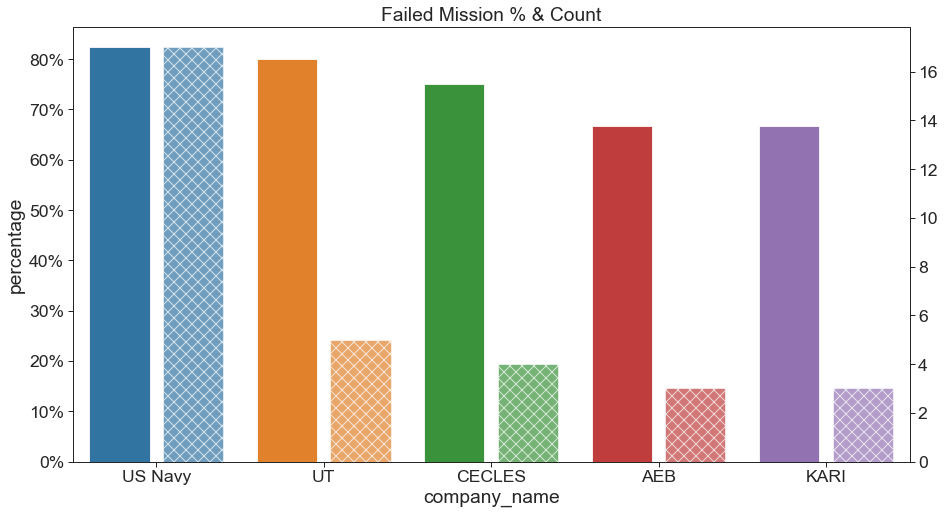

In [19]:
from io import StringIO

from matplotlib.ticker import PercentFormatter

# PLOT A BAR CHART WITH TWIN AXIS
data = ten_company_missions_failed

x_ = data.columns[0]
y_ = data.columns[1]
y_2 = data.columns[2]

data1 = data[[x_, y_]]
data2 = data[[x_, y_2]]
plt.figure(figsize=(15, 8))
sns.color_palette("pastel")
sns.set_style("ticks")
ax = sns.barplot(x=x_, y=y_, data=data1)
width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)
ax.yaxis.set_major_formatter(PercentFormatter(1))

ax2 = ax.twinx()
sns.barplot(x=x_, y=y_2, data=data2, alpha=0.7, hatch="xx", ax=ax2)
for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1 - width_scale))
    bar.set_width(w * width_scale)

ax2.set_ylabel("")
ax2.set_title("Failed Mission % & Count")
plt.savefig("Failed Mission % and Count")

plt.show()

In [20]:
# DEFINE FUNCTION TO PLOT DISTIRBUTIONS


def distributions(data, x, name):
    plt.figure(figsize=(15, 8))
    sns.set_style("darkgrid")
    sns.color_palette("Set2")
    x_ = data[x]
    ax = sns.distplot(x_, kde=False)
    ax.set_title(name)
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    plt.savefig(name)

In [21]:
# CALCULATE NUMBER OF YEARS BETWEEN SELECTION AND FIRST MISSION FOR EACH ASTRONAUT:
astronauts_2 = astronauts.sort_values(
    ["name", "year_of_mission"], ascending=[True, True]
)
astronauts_3 = astronauts_2.groupby("name").nth(0).reset_index()
astronauts_3["time_to_first_mission"] = (
    astronauts_3.year_of_mission - astronauts_3.year_of_selection
)

# EXCLUDE ASTRONAUTS THAT HAVE TIME TO FIRST MISSION <= 0: SEEMS UNLIKELY THAT THIS WOULD BE THE CASE: POTENTIAL DATA QUALITY ISSUES
time_to_first = astronauts_3.loc[astronauts_3.time_to_first_mission > 0]

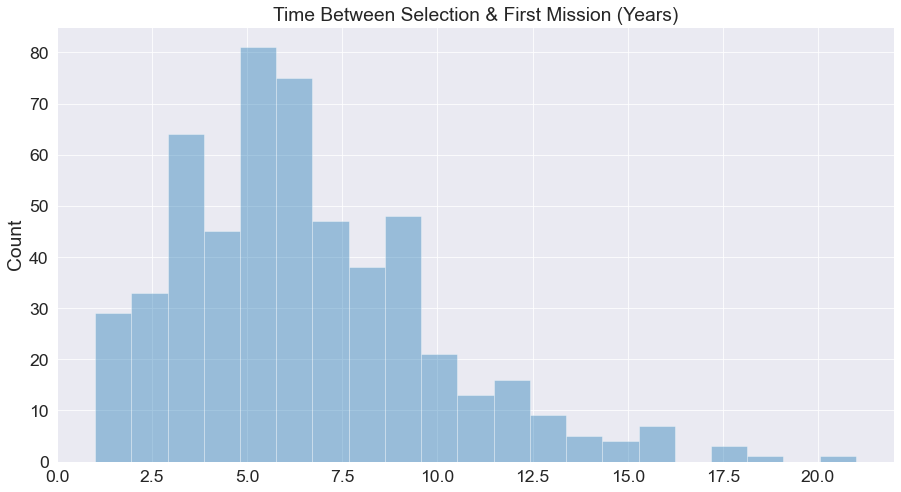

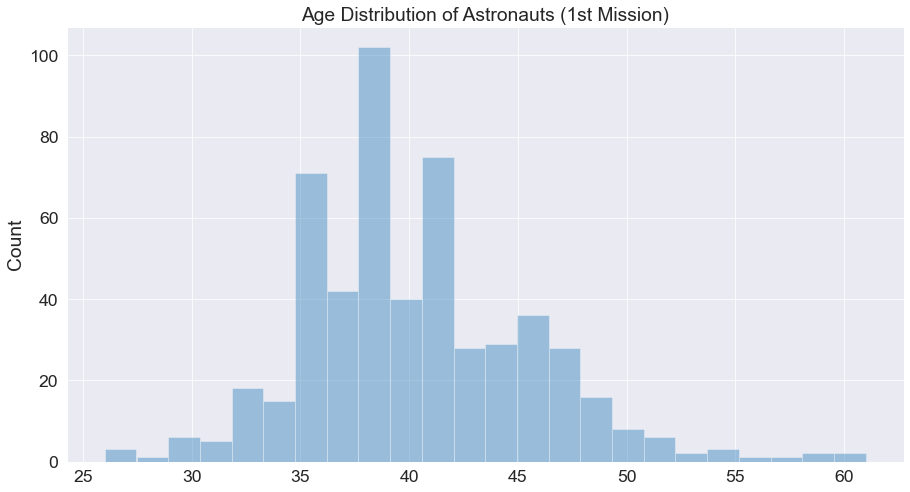

In [22]:
# YEARS TO FIRST MISSION
data = time_to_first
x = "time_to_first_mission"
name = "Time Between Selection & First Mission (Years)"
distributions(data, x, name)

# AGE DISTIRBUTION OF ASTRONAUTS ON FIRST MISSION
data = time_to_first
x = "age_on_mission"
name = "Age Distribution of Astronauts (1st Mission)"
distributions(data, x, name)

In [23]:
# CORRELATION PLOT FOR FAILED MISSION PERCETAGE AGAINST NUMBER OF MISSIONS UNDERTAKEN AT COMPANY LEVEL
failed_missions
failed_missions.corr()

,status_mission_2_x,status_mission_2_y,percentage
status_mission_2_x,1.000000,0.958855,-0.189992
status_mission_2_y,0.958855,1.000000,-0.264347
percentage,-0.189992,-0.264347,1.000000
